In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [2]:
df = pd.read_csv(os.path.join('jigsaw-toxic-comment-classification-challenge','train.csv', 'train.csv'))

In [3]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### 1. Preprocess

In [5]:
from tensorflow.keras.layers import TextVectorization

In [6]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [7]:
MAX_FEATURES = 200000 # number of words in the vocab

In [8]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [9]:
vectorizer.adapt(X.values)

In [10]:
vectorized_text = vectorizer(X.values)

In [11]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [12]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

### 2. Create Sequential Model

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [14]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [15]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [17]:
history = model.fit(train, epochs=1, validation_data=val)

6981/6981 [==============================] - 4479s 640ms/step - loss: 0.0628 - val_loss: 0.0550


In [38]:
history.history

{'loss': [0.06280336529016495], 'val_loss': [0.05504182353615761]}

In [18]:
from matplotlib import pyplot as plt

<Figure size 576x360 with 0 Axes>

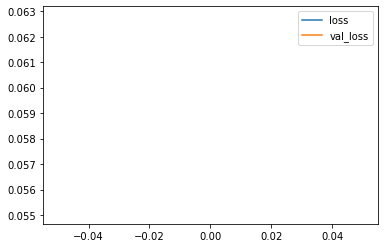

In [31]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

### 3. Make Predictions

In [44]:
input_text = vectorizer('You freaking suck! I am going to hit you.')

In [45]:
input_text

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([   7, 7113,  396, ...,    0,    0,    0], dtype=int64)>

In [46]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [39]:
batch = test.as_numpy_iterator().next()

In [48]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [49]:
(model.predict(batch_X)>0.5).astype(int)

1/1 [==============================] - 0s 200ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [50]:
res = model.predict(np.expand_dims(input_text, 0))

1/1 [==============================] - 0s 75ms/step


In [51]:
res.shape

(1, 6)

### 4. Evaluate Model

In [52]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [53]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [54]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 101ms/step


1/1 [==============================] - 0s 136ms/step


1/1 [==============================] - 0s 112ms/step


1/1 [==============================] - 0s 99ms/step


1/1 [==============================] - 0s 100ms/step


1/1 [==============================] - 0s 99ms/step


1/1 [==============================] - 0s 98ms/step


In [55]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.829206109046936, Recall:0.644859790802002, Accuracy:0.4563691020011902


### 5. Test and Gradio

!pip install gradio jinja2

In [56]:
import tensorflow as tf
import gradio as gr

In [57]:
model.save('toxicity.h5')

In [58]:
model = tf.keras.models.load_model('toxicity.h5')

In [59]:
input_str = vectorizer('hey i freaken hate you!')

In [60]:
res = model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 1s 818ms/step


In [61]:
res

array([[0.6880002 , 0.01652945, 0.31905293, 0.02475387, 0.32855615,
        0.04658294]], dtype=float32)

In [62]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [63]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

C:\Users\Tanuj Bordikar\anaconda3\lib\site-packages\gradio\inputs.py:26: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
C:\Users\Tanuj Bordikar\anaconda3\lib\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
C:\Users\Tanuj Bordikar\anaconda3\lib\site-packages\gradio\deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)
C:\Users\Tanuj Bordikar\anaconda3\lib\site-packages\gradio\deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


In [64]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860/
Running on public URL: https://30423.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x2b648850a60>,
 'http://127.0.0.1:7860/',
 'https://30423.gradio.app')

1/1 [==============================] - 0s 70ms/step
